In [ ]:
%pylab inline
from numba import njit
from matplotlib import animation, rc
from tqdm.notebook import tqdm
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


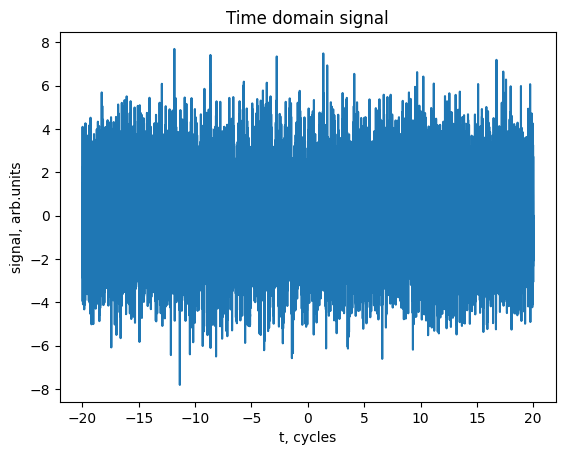

In [ ]:

def time_samples_create(t_min, t_max, n_samples):
    '''Creates n_samples time samples in interval [t_min, t_max] '''

    return np.linspace(t_min * 2*pi, t_max * 2*pi, n_samples)

def signal_create(t):
    '''Creates signal sample for each time sample '''

    y = np.sin(t) * exp(-t**2/2/20**2)
    y = y + np.sin(3*t) * exp(-(t-5*2*pi)**2/2/20**2)
    y = y + np.sin(5.5*t) * exp(-(t-10*2*pi)**2/2/5**2)
    y = y + np.sin(2.4*t) *  exp(-(t+5*2*pi)**2/2/30**2)
    y = y + np.random.normal(scale=np.sqrt(3), size=t.shape)  
    return y

t = time_samples_create(-20, 20, 2**15)
y = signal_create(t)

plt.style.use('default')
plt.plot(t/2/pi, y);

plt.title('Time domain signal')
xlabel('t, cycles');
ylabel('signal, arb.units');

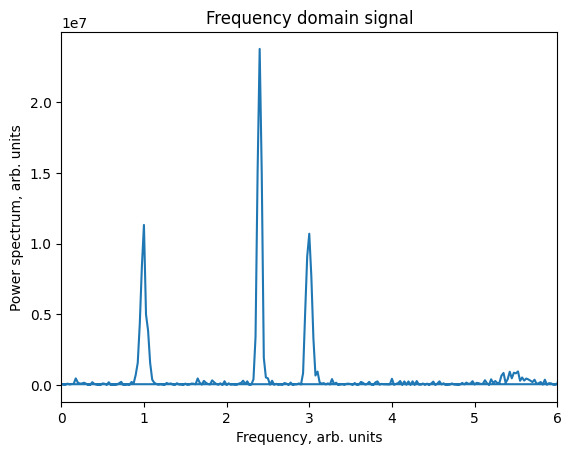

In [ ]:
# Calculate Fast Fourer Transform 
sp = fft.fft(y)
# Get frequences 
w = fft.fftfreq(len(y), d = (t[1]-t[0])/2/pi)
# Plot power dependecy of frequency
plot(w, abs(sp)**2)

# Limit picture, because spectrum has 2 copies 
xlim(0,6)

plt.title('Frequency domain signal')
xlabel('Frequency, arb. units');
ylabel('Power spectrum, arb. units');

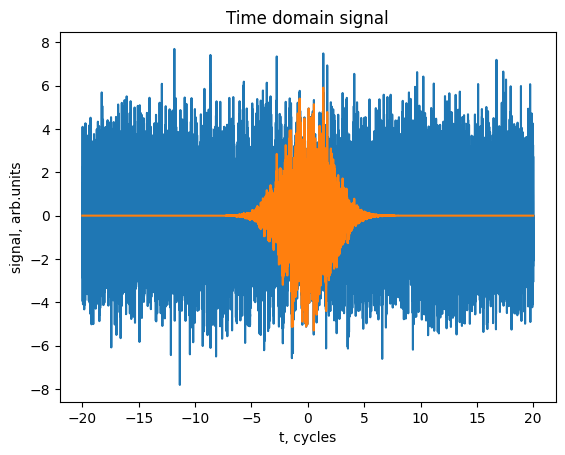

In [ ]:
# Windowed Fourier transform

#Parametres of window 
window_width = 2.0 *2*pi
window_position = 0* 2*pi
window_function = exp(-(t-window_position)**2/2/window_width**2)

# multiply signal to window (getting signal in window)
y_window = y * window_function

#plot 
plot(t/2/pi, y)
plot(t/2/pi, y_window)
plt.title('Time domain signal')
xlabel('t, cycles');
ylabel('signal, arb.units');

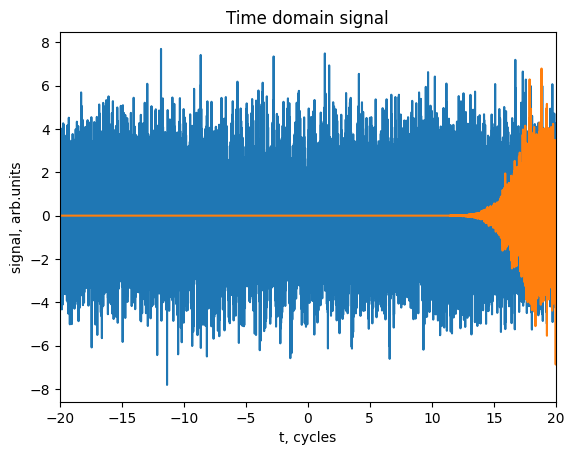

In [ ]:
fig = plt.figure()

ax = plt.axes(xlim=(-20, 20))
line2, = ax.plot(t/2/pi, y, alpha = 1)
line, = ax.plot([], [], alpha = 1)

plt.title('Time domain signal')
xlabel('t, cycles');
ylabel('signal, arb.units');


pos = -20* 2*pi
width = 2.0 *2*pi

def init():
    line.set_data([], [])
    return line,

def animate(i):
    global t, pos, width

    y = signal_create(t) * exp(-(t-pos)**2/2/width**2)
    line.set_data(t/2/pi, y)
    pos+= 2*pi
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=40, interval=60, blit=True)

rc('animation', html='jshtml');
anim 

In [ ]:

@njit(fastmath=True)
def get_window_function(t, position, width):
    '''For each timesample in t with specific position and width
    returns result of windowing '''

    return np.exp(-(t-position)**2/2/width**2)

def get_specgram(t , t_min = -20, t_max = 20, window_width =  2.0 , nwindowsteps = 1000):
    
    samples_in_window = np.linspace(t_min * 2*pi , t_max* 2*pi, nwindowsteps)
    window_width = window_width * 2*pi

    spectrogram = np.empty((len(t), len(samples_in_window)), np.float64)

    for row, step in enumerate(samples_in_window):
        window_position = step
        window_function = get_window_function(t,window_position,window_width)
        res = y*window_function
        spec = fft.fft(res)
        spectrogram[:,row] = abs(spec)

    return spectrogram


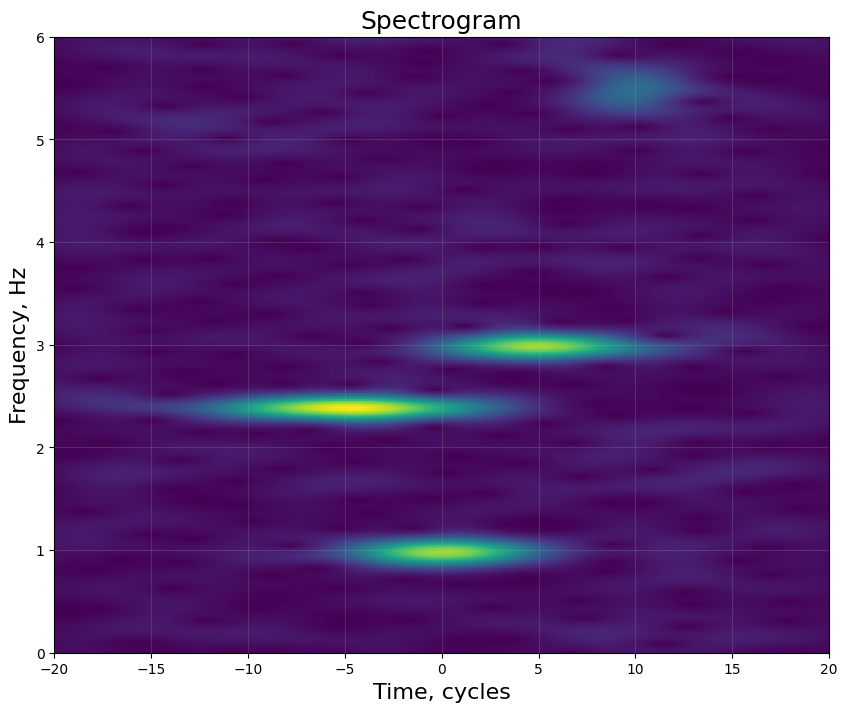

In [ ]:
spectrogram  = get_specgram(t)

plt.figure(figsize=(10,8))
plt.imshow(spectrogram, aspect= 'auto', extent=[-20,20, 0, 1/(t[1]-t[0])*2*pi])
ylim(0,6)
plt.title('Spectrogram', fontsize = 18)
plt.xlabel('Time, cycles', fontsize = 16)
plt.ylabel('Frequency, Hz', fontsize = 16)
plt.grid('--',alpha = 0.2)

In [ ]:
t = time_samples_create(-10, 10, 2**14)
y = signal_create(t)

In [ ]:
%timeit get_specgram(t)

1 loop, best of 3: 1.07 s per loop


In [ ]:
t = time_samples_create(-10, 10, 2**14+1)
y = signal_create(t)


In [ ]:
%timeit get_specgram(t)

1 loop, best of 3: 2.28 s per loop


In [ ]:
t = time_samples_create(-10, 10, 2**14-1)
y = signal_create(t)

In [ ]:
%timeit get_specgram(t)

1 loop, best of 3: 2.39 s per loop




---



In [ ]:
!pip install mpi4py 

     |████████████████████████████████| 1.4MB 4.6MB/s 


In [ ]:
%%writefile spectogram.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import math
import numpy as np
from scipy.fftpack import fft
import scipy.fftpack


def get_specgram_parallel(t, y ,rank, n_processes, t_min = -20, t_max = 20, window_width =  2.0 , nwindowsteps = 2000):

    #split all samples for processes
    samples_in_process = nwindowsteps // n_processes
    #we can have some modulo after dividing
    last_samples = nwindowsteps % n_processes

    #length of the interval where we calculate diagram 
    full_length = t_max*2*pi - t_min*2*pi
    #length of parts that will be calculated by processes
    part_length = full_length // n_processes

    #if the process is last
    if rank == n_processes - 1:
        #it have to calculate part of data with modulo
        samples_in_window = np.linspace(t_min*2*pi + rank*part_length , t_max*2*pi, samples_in_process+last_samples)
    else:
        #other procesess will calculatate the same parts
        samples_in_window = np.linspace(t_min*2*pi + rank*part_length , t_min*2*pi + (rank+1)*part_length, samples_in_process)


    window_width = window_width * 2*pi

    #array for specgram
    spectrogram = np.empty((len(t), len(samples_in_window)), np.float64)


    for row, step in enumerate(samples_in_window):
        window_position = step
        window_function = np.exp(-(t-window_position)**2/2/window_width**2)
        res = y*window_function
        spec = scipy.fftpack.fft(res)
        spectrogram[:,row] = abs(spec)

    return spectrogram

pi = np.pi

#time samples
t =  np.linspace(-20 * 2*pi, 20 * 2*pi, 2**15)

#signal samples
y = np.sin(t) * np.exp(-t**2/2/20**2) + \
    np.sin(3*t) * np.exp(-(t-5*2*pi)**2/2/20**2) + \
    np.sin(5.5*t) * np.exp(-(t-10*2*pi)**2/2/5**2) + \
    np.sin(2.4*t) *  np.exp(-(t+5*2*pi)**2/2/30**2)

#creating mpi communicator
comm = MPI.COMM_WORLD
#getting numper of processes
n_processes = comm.Get_size()
#getting current process
rank = comm.Get_rank()

#if it's the root process
if rank ==0:
    #calculate time of running the program
    print('Number of processors = ', n_processes)
    t_0 = MPI.Wtime()

#do calculations
spectogram  = get_specgram_parallel(t,y, rank, n_processes)
#combine results
spectogram = comm.gather(spectogram, root = 0)

if rank==0:
    a = []
    
    #pasting together our parts
    for i in range(n_processes):
        a.append(spectogram[i])
    
    #out specgram
    out = np.concatenate((a), axis=1)

    #calculate time of running the program
    time = np.round(MPI.Wtime() - t_0,4)
    print(time , 'sec')
    #save it to file
    np.savez('Spec_'+str(n_processes), time)

    #plot specgram
    if(n_processes==10):
        plt.figure(figsize=(10,8))
        plt.imshow(out, aspect= 'auto', extent=[-20,20, 0, 1/(t[1]-t[0])*2*pi])
        plt.ylim(0,6)
        plt.title('Spectrogram', fontsize = 18)
        plt.xlabel('Time, cycles', fontsize = 16)
        plt.ylabel('Frequency, Hz', fontsize = 16)
        plt.grid('--',alpha = 0.2)
        plt.savefig('Spectogram', dpi = 100)
        plt.close()


Writing spectogram.py


Number of processors =  1
2.6878 sec
Number of processors =  2
1.7392 sec
Number of processors =  3
1.6632 sec
Number of processors =  4
1.4071 sec
Number of processors =  5
1.4577 sec
Number of processors =  6
1.4501 sec
Number of processors =  7
1.4537 sec
Number of processors =  8
1.4805 sec
Number of processors =  9
1.5055 sec
Number of processors =  10
1.5642 sec


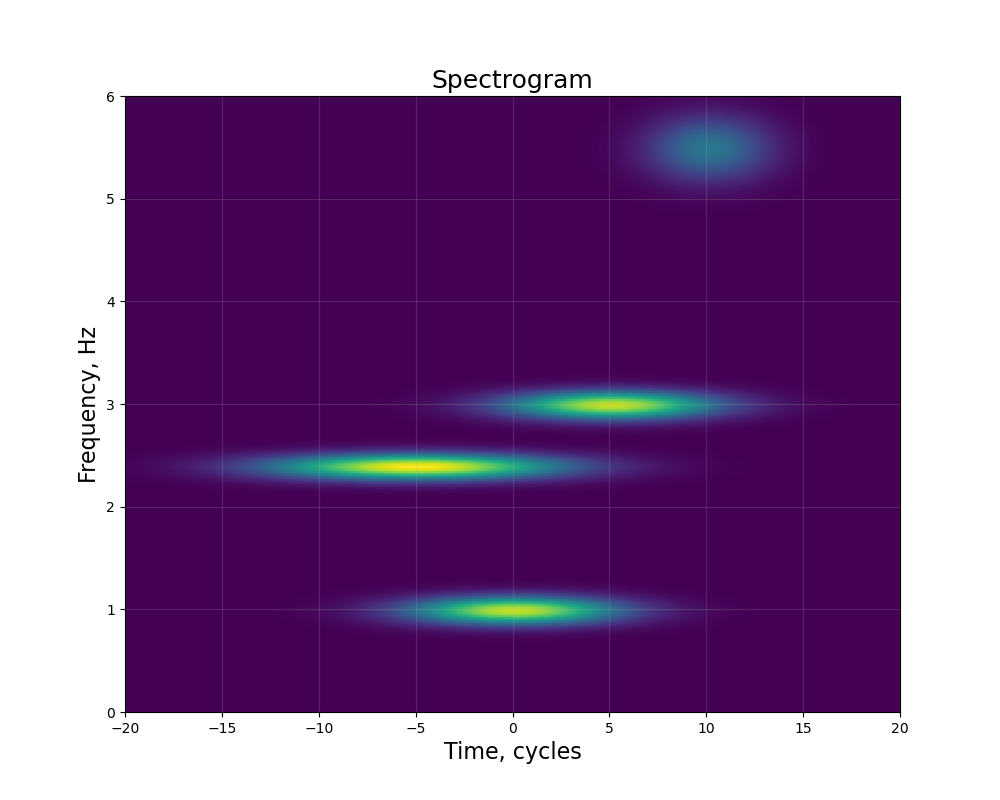

In [ ]:
!mpiexec -n 1 python spectogram.py
!mpiexec -n 2 python spectogram.py
!mpiexec -n 3 python spectogram.py
!mpiexec -n 4 python spectogram.py
!mpiexec -n 5 python spectogram.py
!mpiexec -n 6 python spectogram.py
!mpiexec -n 7 python spectogram.py
!mpiexec -n 8 python spectogram.py
!mpiexec -n 9 python spectogram.py
!mpiexec -n 10 python spectogram.py
from IPython.display import Image
Image("Spectogram.png")

Number of processors =  1
5.653 sec
Number of processors =  2
5.184 sec
Number of processors =  3
5.5712 sec
Number of processors =  4
5.9214 sec
Number of processors =  5
6.0188 sec
Number of processors =  6
6.2602 sec
Number of processors =  7
6.4969 sec
Number of processors =  8
6.6892 sec
Number of processors =  9
6.9537 sec
Number of processors =  10
7.0897 sec


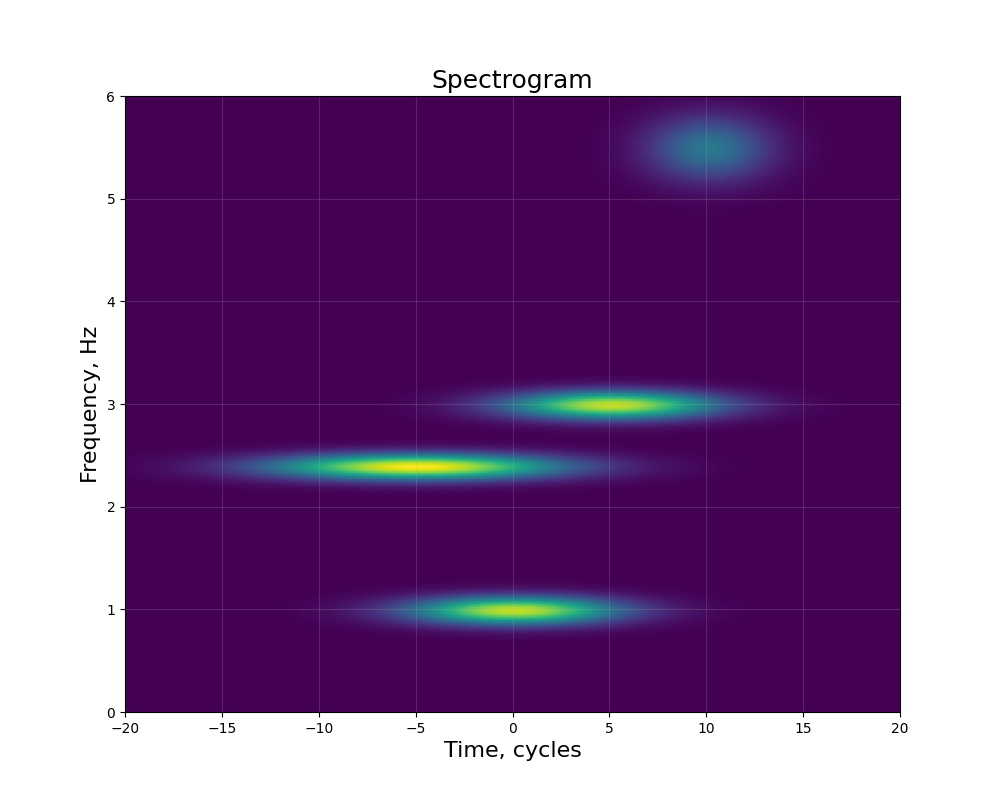

In [ ]:
!mpirun --allow-run-as-root -n 1 python spectogram.py
!mpirun --allow-run-as-root -n 2 python spectogram.py
!mpirun --allow-run-as-root -n 3 python spectogram.py
!mpirun --allow-run-as-root -n 4 python spectogram.py
!mpirun --allow-run-as-root -n 5 python spectogram.py
!mpirun --allow-run-as-root -n 6 python spectogram.py
!mpirun --allow-run-as-root -n 7 python spectogram.py
!mpirun --allow-run-as-root -n 8 python spectogram.py
!mpirun --allow-run-as-root -n 9 python spectogram.py
!mpirun --allow-run-as-root -n 10 python spectogram.py
from IPython.display import Image
Image("Spectogram.png")

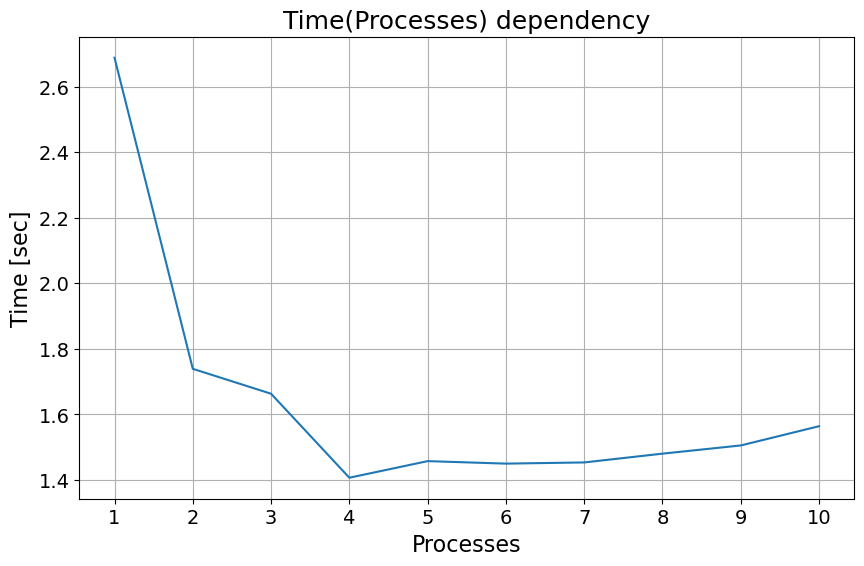

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a = []
b = []
for i in range(1, 11, 1):
    ex = np.load('Spec_'+str(i)+'.npz')
    a.append((ex['arr_0']))
    b.append(1/(ex['arr_0']))
    
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.title('Time(Processes) dependency', fontsize=18)
plt.ylabel('Time [sec]', fontsize=16)
plt.xlabel('Processes', fontsize=16)
plt.xticks(np.arange(0, 11), np.arange(1, 12), fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(np.arange(10),a);

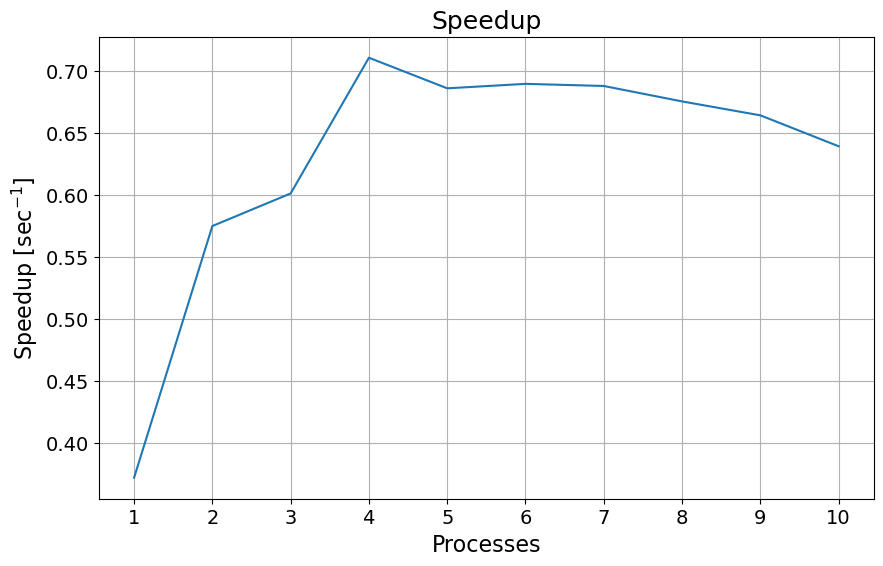

In [ ]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.title('Speedup', fontsize=18)
plt.ylabel('Speedup [sec$^{-1}$]', fontsize=16)
plt.xlabel('Processes', fontsize=16)
plt.xticks(np.arange(0, 11), np.arange(1, 12), fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.plot(np.arange(10),b);